In [1]:
import sys
import subprocess

print("Python executable:", sys.executable)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "openpyxl"])


Python executable: C:\Users\josef\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


0

In [2]:
import openai
from openai import OpenAI

print(openai.__version__)




2.8.1


In [3]:
#import pandas as pd
#import matplotlib.pyplot as plt
#from vllm import LLM, SamplingParams
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    #api_key="dummy-key" - wird nicht gebraucht weil vllm nicht mit internet verbunden ist
)

#MODEL_NAME = "Qwen2-0.5B-Instruct" 

In [4]:
import pandas as pd

df = pd.read_excel("./testdata_MIE.xlsx")
df.to_csv("./testdata_MIE.csv", index=False)

df.head()


,PatientAccountID,MPINumber,AssessmentID,Source,CollectedDT,Finding,FindingName,FindingDataType,Value,AdditionalInformation
0,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jul xx 20xx xx:xxAM,Geburtsdatum,NaN,9,xx/19xx,NaN
1,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jun xx 20xx xx:xxPM,Geschlecht,NaN,1,männlich,NaN
2,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxAM,Diagnose,NaN,1,N18.0,Terminale Niereninsuffizienz
3,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,G63.2*,Diabetische Polyneuropathie
4,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,H36.0*,Retinopathia diabetica


In [5]:
messages = [
    {"role": "user", "content": "Say hello from the Qwen server in one short sentence."}
]

response = client.chat.completions.create(
    model="qwen",  # <-- sehr wichtig!
    messages=messages,
    temperature=0.1,
    max_tokens=100,
)

response.choices[0].message.content





'Hello from the Qwen server!'

In [ ]:
import pandas as pd

def query_template(df: pd.DataFrame, query: str):
    messages = [
        {
            "role": "system",
            "content": (
                "You are a Python code generator for pandas data analysis.\n"
                "A pandas DataFrame named df already exists in memory.\n\n"

                "STRICT RULES (MANDATORY):\n"
                "- Output ONLY executable Python code.\n"
                "- NO explanations, NO comments, NO markdown.\n"
                "- NEVER load files (no read_csv, no file paths).\n"
                "- NEVER overwrite or reassign df.\n"
                "- Use ONLY existing dataframe columns.\n"
                "- The FINAL result MUST be printed using print(...).\n"
                "- Bare expressions without print() are FORBIDDEN.\n\n"

                "BOOLEAN INDEXING (EXACT SYNTAX – MANDATORY):\n"
                "- When combining pandas conditions, use EXACTLY:\n"
                "  (condition_1) & (condition_2)\n"
                "- BOTH condition_1 AND condition_2 MUST be fully enclosed in parentheses.\n"
                "- Correct example:\n"
                "  mask = (df['Finding'] == 'Diagnose') & (df['Value'].str.contains('H36', na=False))\n"
                "- Incorrect (FORBIDDEN):\n"
                "  df['Finding'] == 'Diagnose' & df['Value'].str.contains('H36', na=False)\n"
                "- NEVER use 'and' or 'or' with pandas Series.\n\n"

                "COLUMN VALIDATION (MANDATORY PATTERN):\n"
                "required = {...}\n"
                "missing = required.difference(df.columns)\n"
                "if missing:\n"
                "    raise ValueError(f'Missing required columns: {missing}')\n\n"

                "DATASET SEMANTICS:\n"
                "- The dataset is event-based: each patient has multiple rows.\n"
                "- Patients are identified by MPINumber.\n"
                "- Diagnoses are rows where Finding == 'Diagnose'.\n"
                "- Diagnosis codes are stored in the Value column.\n"
                "- Patient counts MUST use MPINumber.nunique().\n\n"

                "BOX PLOT RULE (MANDATORY):\n"
                "- A box plot MUST visualize a distribution of multiple values.\n"
                "- NEVER use .nunique(), .count(), or any single scalar for a box plot.\n"
                "- For box plots over patients, ALWAYS compute a per-patient distribution using:\n"
                "  df.groupby('MPINumber').size()\n"
                "- For plots: import matplotlib.pyplot as plt\n"
                "- End every plot with plt.tight_layout() and plt.show().\n"
            )
        },

        # Few-shot examples (minimal & correct)
        {
            "role": "user",
            "content": "How many patients got diagnosed with N18?"
        },
        {
            "role": "assistant",
            "content": (
                "required = {'Finding', 'Value', 'MPINumber'}\n"
                "missing = required.difference(df.columns)\n"
                "if missing:\n"
                "    raise ValueError(f'Missing required columns: {missing}')\n"
                "mask = (df['Finding'] == 'Diagnose') & (df['Value'].str.contains('N18', na=False))\n"
                "print(df.loc[mask, 'MPINumber'].nunique())"
            )
        },

        # Real task
        {
            "role": "user",
            "content": query
        }
    ]

    return messages



def ask_llm(df: pd.DataFrame, query: str) -> str:
    messages = query_template(df, query)

    response = client.chat.completions.create(
        model="qwen",
        messages=messages,
        temperature=0.0,
        max_tokens=400,
    )

    return response.choices[0].message.content



## RQ - A
How many people got diagnosed with H36 over time?

In [29]:
query = "How many patients got diagnosed with H36? Consider that each patient can have multiple findings."
response_text = ask_llm(df, query)


print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)


Output:
required = {'Finding', 'Value', 'MPINumber'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
mask = (df['Finding'] == 'Diagnose') & (df['Value'].str.contains('H36', na=False))
print(df.loc[mask, 'MPINumber'].nunique())
#########
2


## RQ - B
How was the age and gender distribution of the disease?

In [30]:
query = "Given the dataframe above, create a pie chart for the Gender distribution."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)


Output:
required = {'Gender'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
gender_counts = df['Gender'].value_counts()
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()
#########
Error while executing LLM-generated code: Missing required columns: {'Gender'}


## RQ - C
What were the five most common secondary diagnoses?

Output:
required = {'Finding', 'Value', 'MPINumber'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
mask = df['Finding'] == 'Diagnose'
secondary_diagnoses = df.loc[mask, 'Value']
top_5 = secondary_diagnoses.value_counts().head(5)
print(top_5.plot(kind='bar'))
#########
Axes(0.125,0.11;0.775x0.77)


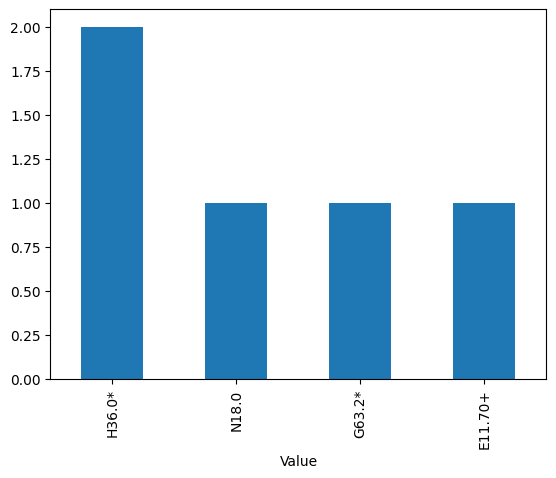

In [31]:
query = "Plot the five most common secondary diagnoses."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)


## RQ - D
How many HBA1C values are there for each patient?

In [32]:

query = "How many the HBA1C values has each diagnosed patient?"

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)

Output:
required = {'Finding', 'Value', 'MPINumber'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
mask = (df['Finding'] == 'Diagnose') & (df['Value'].str.contains('HBA1C', na=False))
patient_values = df.loc[mask, 'MPINumber'].unique()
counts = {}
for patient in patient_values:
    count = df.loc[(df['MPINumber'] == patient) & (df['Value'].str.contains('HBA1C', na=False)), 'Value'].count()
    counts[patient] = count
print(counts)
#########
{}


## RQ - E
Count the number of unique patients diagnosed with H36 and with N18 separately.


In [33]:

query = "Count the number of unique patients diagnosed with H36 and with N18 separately."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)

Output:
required = {'Finding', 'Value', 'MPINumber'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
mask_h36 = (df['Finding'] == 'Diagnose') & (df['Value'].str.contains('H36', na=False))
mask_n18 = (df['Finding'] == 'Diagnose') & (df['Value'].str.contains('N18', na=False))
print(df.loc[mask_h36, 'MPINumber'].nunique())
print(df.loc[mask_n18, 'MPINumber'].nunique())
#########
2
1


## RQ - F
How many unique patients were diagnosed with both H36 and N18?


In [34]:

query = "How many unique patients were diagnosed with both H36 and N18?"

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)

Output:
required = {'Finding', 'Value', 'MPINumber'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
mask = (df['Finding'] == 'Diagnose') & (df['Value'].str.contains('H36', na=False)) & (df['Value'].str.contains('N18', na=False))
print(df.loc[mask, 'MPINumber'].nunique())
#########
0


## RQ - G
Plot a histogram showing how many diagnoses each patient has.


Output:
required = {'MPINumber', 'Finding'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
diagnoses_per_patient = df[df['Finding'] == 'Diagnose']['MPINumber'].value_counts()
print(diagnoses_per_patient.plot(kind='hist'))
#########
Axes(0.125,0.11;0.775x0.77)


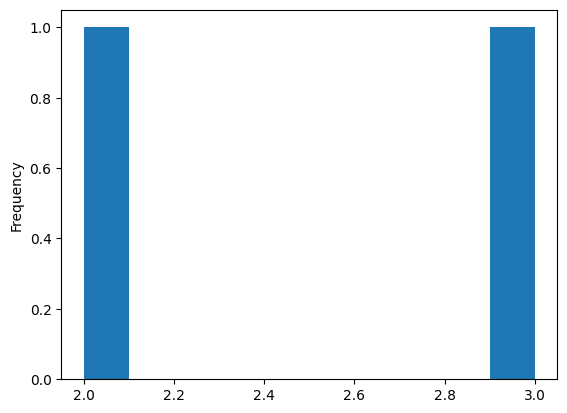

In [35]:

query = "Plot a histogram showing how many diagnoses each patient has."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)

## RQ - H
Create a box plot showing the distribution of the number of diagnoses per patient.



Output:
import matplotlib.pyplot as plt

patient_diagnoses = df.groupby('MPINumber').size()
plt.boxplot(patient_diagnoses)
plt.tight_layout()
plt.show()
#########


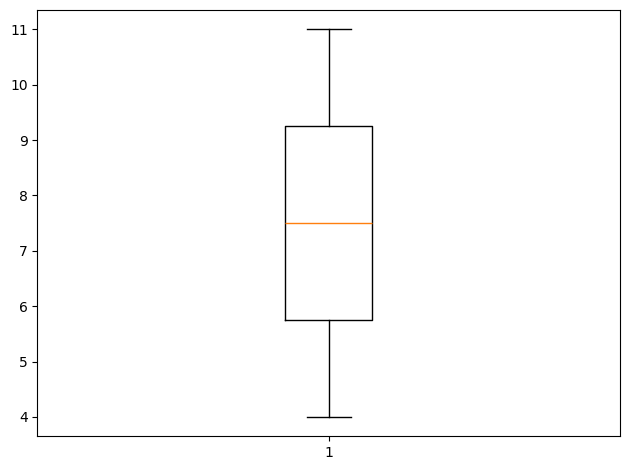

In [38]:

query = "Create a box plot showing the distribution of the number of diagnoses per patient."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)